# Anomaly Detection on Enron Dataset
In this notebook, we aim to build and train models based on machine learning algorithms commonly used for unsupervised anomaly detection; namely one-class Support Vector Machine (SVM), Isolation Forest and Local Outlier Factor (LOF). The dataset used is a modified version of the Enron financial + email dataset that contains information about Enron Corporation, an energy, commodities, and services company that infamously went bankrupt in December 2001 as a result of fraudulent business practices.   
The Enron dataset is widely used to try and develop models that can identify the persons of interests (POIs), i.e. individuals who were eventually tried for fraud or criminal activity in the Enron investigation, from the features within the data. The email + financial data contains the emails themselves, metadata about the emails such as number received by and sent from each individual, and financial information including salary and stock options.  
The dataset we have obtained is from the [Udacity Data Analyst Nanodegree](https://www.udacity.com/course/data-analyst-nanodegree--nd002) and their [GitHub](https://github.com/udacity/ud120-projects) page. Inspiration for loading and preprocessing the dataset was taken from Will Koehrsen's [Medium article](https://williamkoehrsen.medium.com/machine-learning-with-python-on-the-enron-dataset-8d71015be26d). The data is stored in a pickled form and can be downloaded as a `.pkl` file that can be easily converted to a Python dictionary.  
#### NOTE:
All references are presented in the form of appropriate hyperlinks within the paragraphs rather than in a separate section.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

## Loading the Dataset
As mentioned above, the data is presented in the form of a `.pkl.` file. We need to open the file as a Python object and then load it into a dictionary using Python's inbuilt `pickle` module.

In [3]:
import pickle

with open("enron_data.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
len(data_dict)

146

We have 146 personnel in the dataset. Let us view what data each person holds.

In [4]:
data_dict["ALLEN PHILLIP K"]

{'salary': 201955,
 'to_messages': 2902,
 'deferral_payments': 2869717,
 'total_payments': 4484442,
 'loan_advances': 'NaN',
 'bonus': 4175000,
 'email_address': 'phillip.allen@enron.com',
 'restricted_stock_deferred': -126027,
 'deferred_income': -3081055,
 'total_stock_value': 1729541,
 'expenses': 13868,
 'from_poi_to_this_person': 47,
 'exercised_stock_options': 1729541,
 'from_messages': 2195,
 'other': 152,
 'from_this_person_to_poi': 65,
 'poi': False,
 'long_term_incentive': 304805,
 'shared_receipt_with_poi': 1407,
 'restricted_stock': 126027,
 'director_fees': 'NaN'}

Including the names of the people, we have 146 samples with 22 features. We will now convert this to a Pandas dataframe.

In [5]:
temp_dict = {'name':[], 'salary': [], 'to_messages': [],  'deferral_payments': [], 'total_payments': [], 'loan_advances': [],
             'bonus': [], 'email_address': [], 'restricted_stock_deferred': [], 'deferred_income': [], 'total_stock_value': [], 
             'expenses': [], 'from_poi_to_this_person': [], 'exercised_stock_options': [], 'from_messages': [], 'other': [], 
             'from_this_person_to_poi': [], 'long_term_incentive': [], 'shared_receipt_with_poi': [], 'restricted_stock': [], 
             'director_fees': [], 'poi': []}

for name in data_dict.keys():
    temp_dict['name'].append(name)
    for feature in data_dict[name].keys():
        temp_dict[feature].append(data_dict[name][feature])

In [6]:
df = pd.DataFrame(temp_dict)
df

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
0,METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,...,38,NaN,29,1740,1,NaN,702,585062,NaN,False
1,BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,...,NaN,6680544,NaN,2660303,NaN,1586055,NaN,3942714,NaN,False
2,ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,...,NaN,4890344,NaN,12961,NaN,NaN,NaN,1788391,NaN,False
3,CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,...,10,651850,12,NaN,0,NaN,58,386335,NaN,False
4,HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,...,32,5538001,32,11350,21,1617011,1035,853064,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,GRAMM WENDY L,NaN,NaN,NaN,119292,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,119292,False
142,CAUSEY RICHARD A,415189,1892,NaN,1868758,NaN,1000000,richard.causey@enron.com,NaN,-235000,...,58,NaN,49,307895,12,350000,1585,2502063,NaN,True
143,TAYLOR MITCHELL S,265214,533,227449,1092663,NaN,600000,mitchell.taylor@enron.com,NaN,NaN,...,0,3181250,29,NaN,0,NaN,300,563798,NaN,False
144,DONAHUE JR JEFFREY M,278601,865,NaN,875760,NaN,800000,jeff.donahue@enron.com,NaN,-300000,...,188,765920,22,891,11,NaN,772,315068,NaN,False


## Exploratory Data Analysis
Now, we perform some inital data exploration and analysis to get an idea of the characteritics and behaviour of our dataset as well as all the feature columns. We start by using the `.info()` and `.describe()` funtions from the *Pandas* library to get important metrics about our dataset.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   name                       146 non-null    object
 1   salary                     146 non-null    object
 2   to_messages                146 non-null    object
 3   deferral_payments          146 non-null    object
 4   total_payments             146 non-null    object
 5   loan_advances              146 non-null    object
 6   bonus                      146 non-null    object
 7   email_address              146 non-null    object
 8   restricted_stock_deferred  146 non-null    object
 9   deferred_income            146 non-null    object
 10  total_stock_value          146 non-null    object
 11  expenses                   146 non-null    object
 12  from_poi_to_this_person    146 non-null    object
 13  exercised_stock_options    146 non-null    object
 14  from_messa

As seen the above, all our columns except `poi` are of the type objects despite most of the data being numeric values. So, we convert all the necessary columns into `float64` type and also convert the `poi` column to categorical after replacing `True` with `1` and `False` with `0`.

In [8]:
df['salary'] = df['salary'].astype('float64')
df['to_messages'] = df['to_messages'].astype('float64')
df['deferral_payments'] = df['deferral_payments'].astype('float64')
df['total_payments'] = df['total_payments'].astype('float64')
df['loan_advances'] = df['loan_advances'].astype('float64')
df['bonus'] = df['bonus'].astype('float64')
df['restricted_stock_deferred'] = df['restricted_stock_deferred'].astype('float64')
df['deferred_income'] = df['deferred_income'].astype('float64')
df['total_stock_value'] = df['total_stock_value'].astype('float64')
df['expenses'] = df['expenses'].astype('float64')
df['from_poi_to_this_person'] = df['from_poi_to_this_person'].astype('float64')
df['exercised_stock_options'] = df['exercised_stock_options'].astype('float64')
df['from_messages'] = df['from_messages'].astype('float64')
df['other'] = df['other'].astype('float64')
df['from_this_person_to_poi'] = df['from_this_person_to_poi'].astype('float64')
df['long_term_incentive'] = df['long_term_incentive'].astype('float64')
df['shared_receipt_with_poi'] = df['shared_receipt_with_poi'].astype('float64')
df['restricted_stock'] = df['restricted_stock'].astype('float64')
df['director_fees'] = df['director_fees'].astype('float64')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146 entries, 0 to 145
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   name                       146 non-null    object 
 1   salary                     95 non-null     float64
 2   to_messages                86 non-null     float64
 3   deferral_payments          39 non-null     float64
 4   total_payments             125 non-null    float64
 5   loan_advances              4 non-null      float64
 6   bonus                      82 non-null     float64
 7   email_address              146 non-null    object 
 8   restricted_stock_deferred  18 non-null     float64
 9   deferred_income            49 non-null     float64
 10  total_stock_value          126 non-null    float64
 11  expenses                   95 non-null     float64
 12  from_poi_to_this_person    86 non-null     float64
 13  exercised_stock_options    102 non-null    float64

In [9]:
df['poi'].replace( {True:1, False:0}, inplace=True)
df['poi'].astype('category')

df.head()

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
0,METTS MARK,365788.0,807.0,NaN,1061827.0,NaN,600000.0,mark.metts@enron.com,NaN,NaN,...,38.0,NaN,29.0,1740.0,1.0,NaN,702.0,585062.0,NaN,0
1,BAXTER JOHN C,267102.0,NaN,1295738.0,5634343.0,NaN,1200000.0,NaN,NaN,-1386055.0,...,NaN,6680544.0,NaN,2660303.0,NaN,1586055.0,NaN,3942714.0,NaN,0
2,ELLIOTT STEVEN,170941.0,NaN,NaN,211725.0,NaN,350000.0,steven.elliott@enron.com,NaN,-400729.0,...,NaN,4890344.0,NaN,12961.0,NaN,NaN,NaN,1788391.0,NaN,0
3,CORDES WILLIAM R,NaN,764.0,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,...,10.0,651850.0,12.0,NaN,0.0,NaN,58.0,386335.0,NaN,0
4,HANNON KEVIN P,243293.0,1045.0,NaN,288682.0,NaN,1500000.0,kevin.hannon@enron.com,NaN,-3117011.0,...,32.0,5538001.0,32.0,11350.0,21.0,1617011.0,1035.0,853064.0,NaN,1


In [10]:
df.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
count,9.500000e+01,86.000000,3.900000e+01,1.250000e+02,4.000000e+00,8.200000e+01,1.800000e+01,4.900000e+01,1.260000e+02,9.500000e+01,86.000000,1.020000e+02,86.000000,9.300000e+01,86.000000,6.600000e+01,86.000000,1.100000e+02,1.700000e+01,146.000000
mean,5.621943e+05,2073.860465,1.642674e+06,5.081526e+06,4.196250e+07,2.374235e+06,1.664106e+05,-1.140475e+06,6.773957e+06,1.087289e+05,64.895349,5.987054e+06,608.790698,9.190650e+05,41.232558,1.470361e+06,1176.465116,2.321741e+06,1.668049e+05,0.123288
std,2.716369e+06,2582.700981,5.161930e+06,2.906172e+07,4.708321e+07,1.071333e+07,4.201494e+06,4.025406e+06,3.895777e+07,5.335348e+05,86.979244,3.106201e+07,1841.033949,4.589253e+06,100.073111,5.942759e+06,1178.317641,1.251828e+07,3.198914e+05,0.329899
min,4.770000e+02,57.000000,-1.025000e+05,1.480000e+02,4.000000e+05,7.000000e+04,-7.576788e+06,-2.799289e+07,-4.409300e+04,1.480000e+02,0.000000,3.285000e+03,12.000000,2.000000e+00,0.000000,6.922300e+04,2.000000,-2.604490e+06,3.285000e+03,0.000000
25%,2.118160e+05,541.250000,8.157300e+04,3.944750e+05,1.600000e+06,4.312500e+05,-3.896218e+05,-6.948620e+05,4.945102e+05,2.261400e+04,10.000000,5.278862e+05,22.750000,1.215000e+03,1.000000,2.812500e+05,249.750000,2.540180e+05,9.878400e+04,0.000000
50%,2.599960e+05,1211.000000,2.274490e+05,1.101393e+06,4.176250e+07,7.693750e+05,-1.469750e+05,-1.597920e+05,1.102872e+06,4.695000e+04,35.000000,1.310814e+06,41.000000,5.238200e+04,8.000000,4.420350e+05,740.500000,4.517400e+05,1.085790e+05,0.000000
75%,3.121170e+05,2634.750000,1.002672e+06,2.093263e+06,8.212500e+07,1.200000e+06,-7.500975e+04,-3.834600e+04,2.949847e+06,7.995250e+04,72.250000,2.547724e+06,145.500000,3.620960e+05,24.750000,9.386720e+05,1888.250000,1.002370e+06,1.137840e+05,0.000000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,-8.330000e+02,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,609.000000,4.852193e+07,5521.000000,1.303223e+08,1.398517e+06,1.000000


From the above, we can make the following observations:
* A few feature columns have very high maximum values when compared to the rest of the data like `salary, to_messages, total_payments` etc. However, we cannot make an assumption that these are outliers due to the very nature of the data.
* There are a lot of missing values in most of the columns. For the feature columns related to finances, `NaN` is actually 0 whereas it is an unknown value for the email related feature columns according to the [documentation](https://github.com/udacity/ud120-projects/blob/master/final_project/enron61702insiderpay.pdf)
* The columns `name` and `email_id` can be removed or stored separately as they provide no tangible information for our model
* Since many of the columns are arithmetically related to one another, we can check for errors using those relations. 

Now, let us create a PairGrid with the feature columns `salary, total_payments, total_stock_value, from_poi_to_this_person, from_this_person_to_poi` to find any observable relations among them. The main reason we choose these columns specifically is because conceptaully, they seem the most important as well as related to most other feature columns.

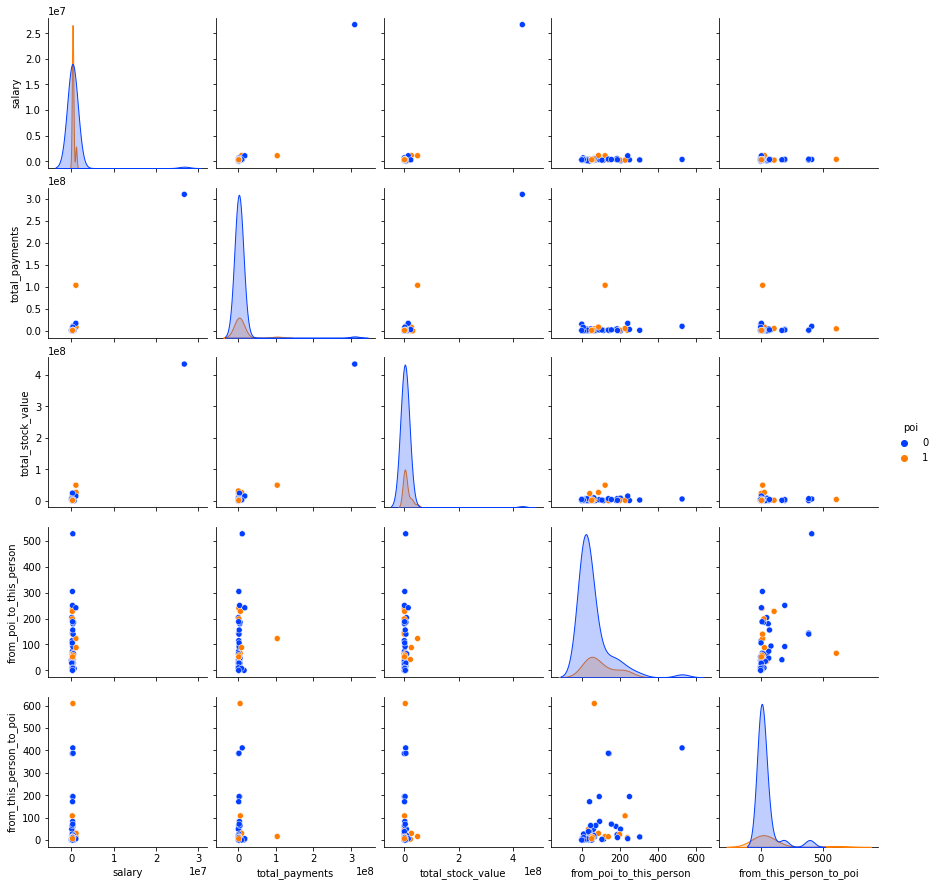

In [11]:
tempdf = df[['salary','total_payments','total_stock_value','from_poi_to_this_person','from_this_person_to_poi','poi']]

sns.pairplot(tempdf, hue='poi', palette='bright')

From the diagonal plots, we can conclude that no one feature is enough to predict whether a given observation can be classified as a person of interest. This is because their is considerbale overlap in the distributions for both categories. 

## Handling missing data
As mentioned above, we have a lot of missing data in our dataset. We cannot remove the columns with missing values because we already have very few observations to work with and removing more could prove detrimental during model training. For the financial feature columns, we replace `NaN` with 0. For the email feature columns, we replace them with the mean of respective category.

In [12]:
financial_features = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'exercised_stock_options',
                      'expenses', 'loan_advances', 'long_term_incentive', 'other', 'restricted_stock', 'restricted_stock_deferred',
                      'salary', 'total_payments', 'total_stock_value']

df[financial_features] = df[financial_features].fillna(0)
df[financial_features].isna().sum()

bonus                        0
deferral_payments            0
deferred_income              0
director_fees                0
exercised_stock_options      0
expenses                     0
loan_advances                0
long_term_incentive          0
other                        0
restricted_stock             0
restricted_stock_deferred    0
salary                       0
total_payments               0
total_stock_value            0
dtype: int64

In [13]:
email_features = ['from_messages', 'from_poi_to_this_person', 'from_this_person_to_poi',
                  'shared_receipt_with_poi', 'to_messages']

email_mean = df[email_features].mean()
df[email_features] = df[email_features].fillna(email_mean)
df.isna().sum()

name                         0
salary                       0
to_messages                  0
deferral_payments            0
total_payments               0
loan_advances                0
bonus                        0
email_address                0
restricted_stock_deferred    0
deferred_income              0
total_stock_value            0
expenses                     0
from_poi_to_this_person      0
exercised_stock_options      0
from_messages                0
other                        0
from_this_person_to_poi      0
long_term_incentive          0
shared_receipt_with_poi      0
restricted_stock             0
director_fees                0
poi                          0
dtype: int64

In [14]:
df.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,restricted_stock_deferred,deferred_income,total_stock_value,expenses,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
count,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,1.460000e+02,146.000000,1.460000e+02,146.000000,1.460000e+02,146.000000,1.460000e+02,146.000000,1.460000e+02,1.460000e+02,146.000000
mean,3.658114e+05,2073.860465,4.387965e+05,4.350622e+06,1.149658e+06,1.333474e+06,2.051637e+04,-3.827622e+05,5.846018e+06,7.074827e+04,64.895349,4.182736e+06,608.790698,5.854318e+05,41.232558,6.646839e+05,1176.465116,1.749257e+06,1.942249e+04,0.123288
std,2.203575e+06,1977.423036,2.741325e+06,2.693448e+07,9.649342e+06,8.094029e+06,1.439661e+06,2.378250e+06,3.624681e+07,4.327163e+05,66.594918,2.607040e+07,1409.571983,3.682345e+06,76.620127,4.046072e+06,902.168879,1.089995e+07,1.190543e+05,0.329899
min,0.000000e+00,57.000000,-1.025000e+05,0.000000e+00,0.000000e+00,0.000000e+00,-7.576788e+06,-2.799289e+07,-4.409300e+04,0.000000e+00,0.000000,0.000000e+00,12.000000,0.000000e+00,0.000000,0.000000e+00,2.000000,-2.604490e+06,0.000000e+00,0.000000
25%,0.000000e+00,904.250000,0.000000e+00,9.394475e+04,0.000000e+00,0.000000e+00,0.000000e+00,-3.792600e+04,2.288695e+05,0.000000e+00,25.750000,0.000000e+00,36.000000,0.000000e+00,6.000000,0.000000e+00,591.500000,8.115000e+03,0.000000e+00,0.000000
50%,2.105960e+05,2073.860465,0.000000e+00,9.413595e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000e+00,9.659550e+05,2.018200e+04,64.895349,6.082935e+05,608.790698,9.595000e+02,41.232558,0.000000e+00,1176.465116,3.605280e+05,0.000000e+00,0.000000
75%,2.708505e+05,2073.860465,9.684500e+03,1.968287e+06,0.000000e+00,8.000000e+05,0.000000e+00,0.000000e+00,2.319991e+06,5.374075e+04,64.895349,1.714221e+06,608.790698,1.506065e+05,41.232558,3.750648e+05,1176.465116,8.145280e+05,0.000000e+00,0.000000
max,2.670423e+07,15149.000000,3.208340e+07,3.098866e+08,8.392500e+07,9.734362e+07,1.545629e+07,0.000000e+00,4.345095e+08,5.235198e+06,528.000000,3.117640e+08,14368.000000,4.266759e+07,609.000000,4.852193e+07,5521.000000,1.303223e+08,1.398517e+06,1.000000


## Error Checking through Official Docs
One simple way to check for incorrect data is to add up all of the payment-related columns for each person and check if that is equal to the total payment recorded for the individkual. The same can be done for stock payments. Depending on the result, we can possibly make simple changes to rectify the errors.

In [15]:
payment_data = ['bonus', 'deferral_payments', 'deferred_income', 'director_fees', 'expenses', 'loan_advances', 
                'long_term_incentive', 'other', 'salary']

pay_err = df[ (df[payment_data].sum(axis='columns') != df['total_payments']) ]
pay_err

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
24,BELFER ROBERT,0.0,2073.860465,-102500.0,102500.0,0.0,0.0,NaN,44093.0,0.0,...,64.895349,3285.0,608.790698,0.0,41.232558,0.0,1176.465116,0.0,3285.0,0
117,BHATNAGAR SANJAY,0.0,523.000000,0.0,15456290.0,0.0,0.0,sanjay.bhatnagar@enron.com,15456290.0,0.0,...,0.000000,2604490.0,29.000000,137864.0,1.000000,0.0,463.000000,-2604490.0,137864.0,0


For the payment related financial feature columns, we get error for two observations.The errors appear to be caused by a misalignment of the columns when compared to the [official documentation](https://github.com/udacity/ud120-projects/blob/master/final_project/enron61702insiderpay.pdf); for `BELFER ROBERT`, the financial data has been shifted one column to the right, and for `BHATNAGAR SANJAY`, the data has been shifted one column to the left. We shift the columns to their correct positions and then check again.

In [16]:
df.loc[24,['deferred_income','deferral_payments','expenses',
           'director_fees','total_payments','exercised_stock_options',  'restricted_stock', 
           'restricted_stock_deferred', 'total_stock_value']] = [-102500,0,3285,102500,3285,0,44093,-44093,0]

df.loc[117,['other','expenses','director_fees','total_payments','exercised_stock_options',  'restricted_stock', 
           'restricted_stock_deferred', 'total_stock_value']] = [0,137864,0,137864,15456290,2604490,-2604490,15456290]

pay_err = df[ (df[payment_data].sum(axis='columns') != df['total_payments']) ]
pay_err

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi


In [17]:
stock_data = ['exercised_stock_options', 'restricted_stock', 'restricted_stock_deferred', 'total_stock_value']

stock_err = df[ (df[stock_data[:-1]].sum(axis='columns') != df['total_stock_value']) ]
stock_err

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi


As expected, we rectified errors in our stock data along with the payment data in the code block above.  
Now, we also remove two columns from the dataset namely `TOTAL` and `THE TRAVEL AGENCY IN THE PARK` as the first is unneccessary for prediction and the second is an organization rather than a person.

In [18]:
df[ (df['name'] == 'TOTAL') | (df['name'] == 'THE TRAVEL AGENCY IN THE PARK') ]

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi
100,THE TRAVEL AGENCY IN THE PARK,0.0,2073.860465,0.0,362096.0,0.0,0.0,NaN,0.0,0.0,...,64.895349,0.0,608.790698,362096.0,41.232558,0.0,1176.465116,0.0,0.0,0
103,TOTAL,26704229.0,2073.860465,32083396.0,309886585.0,83925000.0,97343619.0,NaN,-7576788.0,-27992891.0,...,64.895349,311764000.0,608.790698,42667589.0,41.232558,48521928.0,1176.465116,130322299.0,1398517.0,0


In [19]:
df.drop(labels=[100,103], axis=0, inplace=True)
df[ (df['name'] == 'TOTAL') | (df['name'] == 'THE TRAVEL AGENCY IN THE PARK') ]

,name,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees,poi


## Data Preprocessing
All the above steps do come under preprocessing, but this section will deal with the final touches before we start building and training our models. We need to remove the `name` and `email_address` columns followed by scaling using z-score normalization.

In [20]:
names = df.pop('name')
emails = df.pop('email_address')

In [21]:
y = df.pop('poi')
y

0      0
1      0
2      0
3      0
4      1
      ..
141    0
142    1
143    0
144    0
145    1
Name: poi, Length: 144, dtype: int64

Here, the index of `y` should be noted.

In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(copy=True)
scaled_arr = scaler.fit_transform(df)

scaled_df = pd.DataFrame(scaled_arr, columns=financial_features+email_features)
scaled_df.head()

,bonus,deferral_payments,deferred_income,director_fees,exercised_stock_options,expenses,loan_advances,long_term_incentive,other,restricted_stock,restricted_stock_deferred,salary,total_payments,total_stock_value,from_messages,from_poi_to_this_person,from_this_person_to_poi,shared_receipt_with_poi,to_messages
0,0.918440,-0.638449,-0.296586,-0.124319,-0.086077,-0.061843,0.193278,0.321987,-0.389196,1.264300,-4.024698e-01,-0.441284,-0.409903,-0.259004,-0.523277,-0.492058,-0.524099,-0.160507,-0.320349
1,0.415855,0.000000,1.428261,0.398324,-0.086077,0.426412,0.193278,-1.973813,1.216989,-0.548883,-2.126554e-16,0.920370,0.000000,2.098752,0.000000,1.824052,0.000000,1.523879,-0.320349
2,-0.073871,0.000000,-0.296586,-0.221487,-0.086077,-0.265283,0.193278,-0.341762,0.585836,0.920708,-2.126554e-16,0.555485,0.000000,-0.249053,0.000000,-0.492058,0.000000,0.443150,-0.320349
3,-0.944434,-0.660120,-0.296586,-0.245687,-0.086077,-0.550099,0.193278,0.321987,-0.316693,-0.793262,-8.214700e-01,-0.308422,-0.421922,-0.260547,-0.536284,-0.492058,-1.235469,-0.260199,-0.320349
4,0.294601,-0.518506,-0.296586,-0.212691,-0.086077,0.670539,0.193278,-4.840892,0.539807,-0.050546,-4.922556e-01,0.687493,-0.407782,-0.250481,-0.263151,1.869257,-0.156264,-0.026062,-0.320349


In [23]:
scaled_df.index

RangeIndex(start=0, stop=144, step=1)

Clearly, the index of `scaled_df` and `y` are different. This is becuase the scaling resetted our index and now includes the index 100 & 103 een though we removed those samples before. So, we need to realign `y` so that they match.

In [24]:
y.index = scaled_df.index
y

0      0
1      0
2      0
3      0
4      1
      ..
139    0
140    1
141    0
142    0
143    1
Name: poi, Length: 144, dtype: int64

## Visualisation
Now, we will try to visualise our feature space by using t-Stochastic Neighbour Embedding as a dimensionality reduction method. Since this method is primarily used for visualisation, our embedding space is set to be 2 dimensional. Our aim is to observe whether we can achieve a embedding feature space where the anomalous observations are distinctly separate from the non-anomalous ones.

In [25]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)

tsne.fit_transform(scaled_df)

array([[ 1.10669637e+00, -5.39375877e+00],
       [-4.61815500e+00, -6.56869698e+00],
       [-1.84750378e+00, -3.32514262e+00],
       [-4.83855867e+00,  2.50067902e+00],
       [-5.46624708e+00, -6.03274584e+00],
       [ 5.83249927e-02, -2.76719069e+00],
       [-7.78705025e+00,  3.25805974e+00],
       [ 3.07290530e+00, -6.15556955e+00],
       [-2.75070262e+00, -7.21513224e+00],
       [-2.81944513e+00, -5.10960007e+00],
       [-8.07297611e+00,  3.36142492e+00],
       [-1.58940744e+00,  1.07235384e+00],
       [ 3.36994815e+00, -5.22989178e+00],
       [ 2.57542515e+00, -2.79648423e+00],
       [-6.18044329e+00,  2.59085345e+00],
       [-5.22042274e-01,  2.10872817e+00],
       [-9.10562634e-01, -6.87508869e+00],
       [-6.07816696e+00, -4.16306925e+00],
       [-6.41903210e+00, -2.50524431e-01],
       [ 7.17339993e-01, -6.64817631e-01],
       [ 1.41843393e-01,  1.99975863e-01],
       [-5.90688515e+00, -2.51409698e+00],
       [-5.51425457e-01, -9.36381054e+00],
       [ 2.

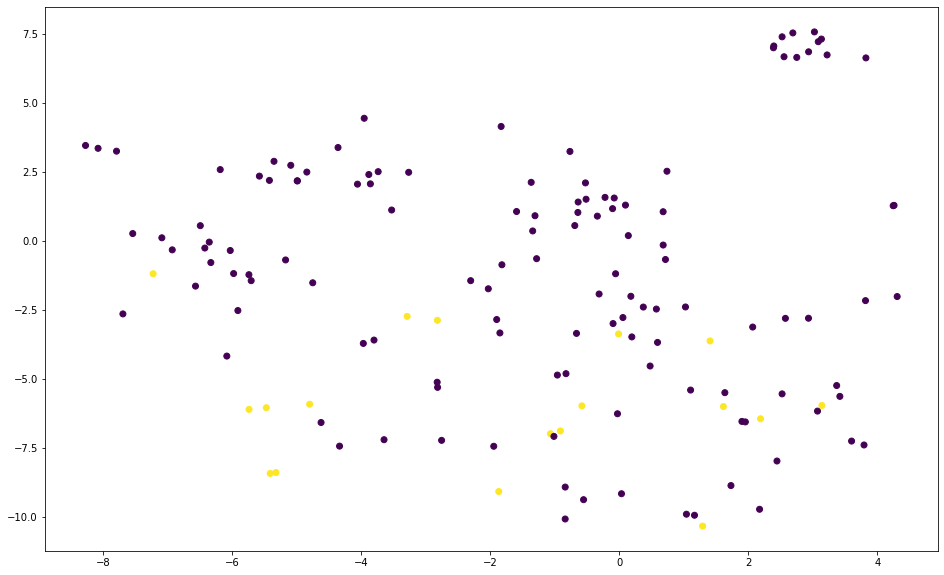

In [26]:
x1 = []
x2 = []
for value in tsne.embedding_:
    x1.append(value[0])
    x2.append(value[1])
    
plt.figure(figsize=(16, 10)) 
plt.scatter(x1,x2,c=y)

As seen above, the compression of our data into 2 dimensions does not show an immediate distinction between non-pois and pois.

## Is splitting needed?
When dealing with supervised algorithms, it is an essential step to split our dataset into training, validation and test sets. Training set is used to train our model. Then, the validaion set is used to tune its hyperparameters. Usually, we skip this split and instead use cross-validation for tuning. Finally, the test set is used to give the true accuracy that can be expected after deployment.  
However, doing the same for unsupervised learning does not make sense. Unsupervised learning in general benefit more from a cross-validation score to replace the metric of test accuracy. Refer this [question from Stats.StackExchange](https://stats.stackexchange.com/questions/387326/unsupervised-learning-train-test-division) and this [one from StackOverflow](https://stackoverflow.com/questions/31673388/is-train-test-split-in-unsupervised-learning-necessary-useful) to know more in detail.  
#### For our case, we will be looking at the accuracy and the confusion matrix since we have labels for our data.

In [27]:
X = scaled_df.copy()
y.value_counts()

0    126
1     18
Name: poi, dtype: int64

In [28]:
(18/144)*100

12.5

We can now begin building our models.

## One-class SVM
The best and most comprehensive explanation for this method is present in the [original paper](https://papers.nips.cc/paper/1999/file/8725fb777f25776ffa9076e44fcfd776-Paper.pdf) authored by researchers from Microsoft, Australian National University and University of London. The gist of it is that regular kernel SVM for classification cannot be used in cases for novelty detection, so minor modifications were made to find a function that is positive for regions with high density of points, and negative for small densities. We will now build and train our model. It is important to remember that this is an unsupervised method, meaing our labels have no use here. The main difference of one class SVM from the other methods is that it is looking for outliers according to the distribution in the feature space, rather than using an index or metric to quantify the anomalous behaviour of one observation with respect to the rest.

In [29]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM()

svmpred = svm.fit_predict(X)

The `fit_predict()` function returns -1 for outliers and 1 for inliers, which is different from how are labels are assigned. So, we will modify the results and then calculate accuracy.

In [30]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

act_svmpred = np.where(svmpred == -1, 1, 0)
print(accuracy_score(y, act_svmpred))
print(f1_score(y, act_svmpred))

0.5625
0.30769230769230765


We get an accuracy of 56.25% with our default model. According to the [Scikit-Learn documentation](https://scikit-learn.org/stable/modules/outlier_detection.html#overview-of-outlier-detection-methods), one-class SVM is very sensitive to outliers in our data which are not anomalies. This might indicate the low training accuracy as we do have a few observations in our dataset that may seem like outliers and hence should have `poi=1` but aren't anomalies per say. However, out F-score is very low. We can interpret this further by getting the confusion matrix

In [31]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y,act_svmpred, labels=[0,1])

array([[67, 59],
       [ 4, 14]], dtype=int64)

From drawing out the confusion matrix, we get a clearer picture of why our F-score is so low. Our model is very good at classifying our anomalies correctly but has a very high error in misclassifying many of normal observations as anomalies. This means we have good recall but very bad precision.

## Isolation Forest
The original paper can be found [here](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest). This is also an unsupervised algorithm that returns an anomaly score for each observation. As the name suggests, it is based on the random forests algorithm in terms of its working.

In [32]:
from sklearn.ensemble import IsolationForest

isof = IsolationForest()

isofpred = isof.fit_predict(X)

In [33]:
act_isofpred = np.where(isofpred == -1, 1, 0)
print(accuracy_score(y, act_isofpred))
print(f1_score(y, act_isofpred))

0.8680555555555556
0.3448275862068966


This is excellent accuracy for what is a very small dataset but very low F-score. Since our model is unsupervised, there is a small possibility that our model overfit the data.

In [34]:
confusion_matrix(y,act_isofpred, labels=[0,1])

array([[120,   6],
       [ 13,   5]], dtype=int64)

Here, we can clearly see that our model has very bad recall, about 22% (4/18) causing the F-score to fall. However, it is very good at classifying a non-anomalous observation correctly. This indicates that when our model predicts a new observation to be normal, we can use that result with utmost trust as it was able to identify 120 of 126 normal training observations. However, if it predicts a new observation as an anomaly, we need to more information or need to look at other methods.

## Local Outlier Factor
The original paper can be found [here](https://www.dbs.ifi.lmu.de/Publikationen/Papers/LOF.pdf). LOF is based on a concept of a local density, where locality is given by K nearest neighbors, whose distance is used to estimate the density. By comparing the local density of an object to the local densities of its neighbors, one can identify regions of similar density, and points that have a substantially lower density than their neighbors. It shares a lot of similarties with the DBSCAN clsutering algorithm.

In [35]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor()

lofpred = lof.fit_predict(X)

In [36]:
act_lofpred = np.where(lofpred == -1, 1, 0)
print(accuracy_score(y, act_lofpred))
print(f1_score(y, act_lofpred))

0.6527777777777778
0.28571428571428575


We get an accuracy of 65%, which is higher than our SVM but lower than our forest but the same F-score as the Forest.

In [37]:
confusion_matrix(y,act_lofpred, labels=[0,1])

array([[84, 42],
       [ 8, 10]], dtype=int64)

Just like the results above, our confusion matrix is an average of the above two methods. While SVM was good at classifying anomalies and Isolation Forest was good at classifying normal observations, LOF lies right between the two.

## Hyperparameter Tuning
We will now take our Isolation Forest model and try tuning it various parameters to get as good a score as possible using `GridSearchCV` cross-validation method. We will concentrating on the `n_estimators` (number of trees in the forest), `max_samples` (number of observations taken for training per tree), `max_features` (number of features taken for splitting per tree) and `bootstrap` (bootstrapping of the data). Two metrics will be calculated, F-score and Accuracy and the best estimator will be decided by the former as we already get excellent accuracy from a default Isolation Forest.

In [69]:
from sklearn.model_selection import GridSearchCV


clf = IsolationForest(random_state=0)
param_grid = {'n_estimators':[100,200,300], 'max_samples':[50,100,'auto'], 'max_features':[1,5,10,15], 
              'bootstrap':[True,False]}

grid_isof = GridSearchCV(clf, param_grid, scoring=['f1_micro','accuracy'], refit='f1_micro', cv=5)
grid_isof.fit(X, np.where(y==1, -1, 1))

GridSearchCV(cv=5, estimator=IsolationForest(random_state=0),
             param_grid={'bootstrap': [True, False],
                         'max_features': [1, 5, 10, 15],
                         'max_samples': [50, 100, 'auto'],
                         'n_estimators': [100, 200, 300]},
             refit='f1_micro', scoring=['f1_micro', 'accuracy'])

In [70]:
grid_isof.best_estimator_

IsolationForest(max_features=10, n_estimators=300, random_state=0)

Here, we obtain our best model. Let us look at the accuracy and F-score to see our improvements.

In [71]:
grid_isof.best_index_

62

In [72]:
print(grid_isof.cv_results_['mean_test_accuracy'][grid_isof.best_index_])
print(grid_isof.cv_results_['mean_test_f1_micro'][grid_isof.best_index_])

0.874384236453202
0.874384236453202


While we see only a small improvement in our accuracy, our F-score has greatly improved.

## Final Thoughts:
* With the default models, Isolation Forest worked best in identifying normal observations whereas one class SVM worked best in identifying anomalies
* LOF's performance was the average of the other two and did not provide any significant advantage.
* Hyperparameter tuning goes a long way in imporving our model. We have done so for our Isolation Forest but the same can be replicated for SVM.
* The main problem with this dataset is a very small number of observations. ML models generally tend to imporve in performance with an increase in data used for training, with overfitting bein prevented by using common methods.
* Supervised Learning algorithms, especially Random Forests, might prove to perform better since our data is labelled but they require finer tuning since their algorithms are not designed for anomaly detection specifically.